# PAMTRA interface to ICON

This example will reproduce the plots in figures 3 and 4 of the PAMTRA manuscript.

In this example we separate the "computing" and the "plotting" stages of the analysis. The computing stage takes up to 20 minutes to run and save the output on files on the disk (approx 400 MB). Once the computations are done you can play with the plotting part several times without having to run the simulations again.

Data required to run the script can be foudn in [example_data]("https://uni-koeln.sciebo.de/s/28700CuFssmin8q"):

  * ICON output: `METEOGRAM_20151119_joyce_5min.nc`
  
Start importing essential modules and do some general settings.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import netCDF4 as nc

import pyPamtra

cores = 4 # number of parallel cores - set to an integer value or to the string 'auto'
ICON_filename = 'data/METEOGRAM_20151119_joyce_5min.nc' # name of the ICON output meteogram

## Computing

Define the hydrometeor properties using a numpy array descriptorFile. Use pandas DataFrame to visualize the table of settings in a easier way.

In [2]:
descriptorFile = np.array([
      #['hydro_name' 'as_ratio' 'liq_ice' 'rho_ms' 'a_ms' 'b_ms' 'alpha_as' 'beta_as' 'moment_in' 'nbin' 'dist_name' 'p_1' 'p_2' 'p_3' 'p_4' 'd_1' 'd_2' 'scat_name' 'vel_size_mod' 'canting']
       ('cwc_q', 1.0,  1, -99.0,   -99.0, -99.0,  -99.0, -99.0, 13, 100, 'mgamma', -99.0, -99.0,   2.0,    1.0,   2.0e-6,   8.0e-5, 'mie-sphere', 'corPowerLaw_24388657.6_2.0', -99.0),
       ('iwc_q', 1.0, -1, -99.0, 1.58783,  2.56,  0.684,   2.0, 13, 100, 'mgamma', -99.0, -99.0, 1.564, 0.8547, 1.744e-5, 9.369e-3, 'ssrg-rt3',   'corPowerLaw_30.606_0.5533',  -99.0),
       ('rwc_q', 1.0,  1, -99.0,   -99.0, -99.0,  -99.0, -99.0, 13, 100, 'mgamma', -99.0, -99.0,   2.0,    1.0,  0.00012,   8.2e-3, 'mie-sphere', 'corPowerLaw_494.74_0.7031',  -99.0),
       ('swc_q', 0.6, -1, -99.0,   0.038,   2.0, 0.3971,  1.88, 13, 100, 'mgamma', -99.0, -99.0,   1.0,    1.0,  5.13e-5, 2.294e-2, 'ssrg-rt3',   'corPowerLaw_5.511054_0.25',  -99.0),
       ('gwc_q', 1.0, -1, -99.0,  500.86,  3.18,  -99.0, -99.0, 13, 100, 'mgamma', -99.0, -99.0,  5.37,   1.06,  2.11e-4,   1.3e-2, 'mie-sphere', 'corPowerLaw_406.67_0.85',    -99.0), 
       ('hwc_q', 1.0, -1, -99.0,  392.33,   3.0,  -99.0, -99.0, 13, 100, 'mgamma', -99.0, -99.0,   5.0,    1.0,  1.87e-4,   1.1e-2, 'mie-sphere', 'corPowerLaw_106.33_0.5',     -99.0)],
      dtype=[('hydro_name', 'S15'), ('as_ratio', '<f8'), ('liq_ice', '<i8'), ('rho_ms', '<f8'), ('a_ms', '<f8'), ('b_ms', '<f8'), ('alpha_as', '<f8'), ('beta_as', '<f8'), ('moment_in', '<i8'), ('nbin', '<i8'), ('dist_name', 'S15'), ('p_1', '<f8'), ('p_2', '<f8'), ('p_3', '<f8'), ('p_4', '<f8'), ('d_1', '<f8'), ('d_2', '<f8'), ('scat_name', 'S20'), ('vel_size_mod', 'S30'), ('canting', '<f8')]
      )
DF = pd.DataFrame(descriptorFile)
DF

,hydro_name,as_ratio,liq_ice,rho_ms,a_ms,b_ms,alpha_as,beta_as,moment_in,nbin,dist_name,p_1,p_2,p_3,p_4,d_1,d_2,scat_name,vel_size_mod,canting
0,cwc_q,1.0,1,-99.0,-99.00000,-99.00,-99.0000,-99.00,13,100,mgamma,-99.0,-99.0,2.000,1.0000,0.000002,0.000080,mie-sphere,corPowerLaw_24388657.6_2.0,-99.0
1,iwc_q,1.0,-1,-99.0,1.58783,2.56,0.6840,2.00,13,100,mgamma,-99.0,-99.0,1.564,0.8547,0.000017,0.009369,ssrg-rt3,corPowerLaw_30.606_0.5533,-99.0
2,rwc_q,1.0,1,-99.0,-99.00000,-99.00,-99.0000,-99.00,13,100,mgamma,-99.0,-99.0,2.000,1.0000,0.000120,0.008200,mie-sphere,corPowerLaw_494.74_0.7031,-99.0
3,swc_q,0.6,-1,-99.0,0.03800,2.00,0.3971,1.88,13,100,mgamma,-99.0,-99.0,1.000,1.0000,0.000051,0.022940,ssrg-rt3,corPowerLaw_5.511054_0.25,-99.0
4,gwc_q,1.0,-1,-99.0,500.86000,3.18,-99.0000,-99.00,13,100,mgamma,-99.0,-99.0,5.370,1.0600,0.000211,0.013000,mie-sphere,corPowerLaw_406.67_0.85,-99.0
5,hwc_q,1.0,-1,-99.0,392.33000,3.00,-99.0000,-99.00,13,100,mgamma,-99.0,-99.0,5.000,1.0000,0.000187,0.011000,mie-sphere,corPowerLaw_106.33_0.5,-99.0


Import automatically the content of the ICON output file. A number of warnings will be displayed.

In [3]:
pam = pyPamtra.importer.readIcon2momMeteogram(ICON_filename, descriptorFile)

/home/mech/lib/python/pyPamtra/core.py:837: Warning: lat set to 50.938056
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:837: Warning: lon set to 6.956944
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:837: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:837: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:837: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:870: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:880: Warning: hydro_reff set to 0
  warnings.warn(qValue + " set to 0", Warning)
/home/mech/lib/python/pyPamtra/core.py:891: Wa

General settings for the Doppler spectra simulations

In [4]:
pam.nmlSet['active'] = True
pam.nmlSet['radar_mode'] = 'spectrum'
pam.nmlSet['passive'] = False # Passive is time consuming
pam.set['verbose'] = 0 # set verbosity levels
pam.set['pyVerbose'] = 0 # change to 2 if you want to see job progress number on the output
pam.p['turb_edr'][:] = 1.0e-4
pam.nmlSet['radar_airmotion'] = True
#pam.nmlSet['radar_airmotion_vmin'] = 0.0 # workaround to potential bug in radar_spectrum
pam.nmlSet['radar_airmotion_model'] = 'constant'

Instrument specific settings (X-band radar KiXPol) and run the simulation (approx 1 min on 8 cores). Save output file into netcdf

In [5]:
pam.nmlSet['radar_fwhr_beamwidth_deg']=1.3
pam.nmlSet['radar_integration_time']=1.0
pam.nmlSet['radar_max_v']=9.0
pam.nmlSet['radar_min_v']=-9.0
pam.nmlSet['radar_nfft']=1200
pam.nmlSet['radar_no_ave']=1
pam.nmlSet['radar_pnoise0']=-20.0
pam.runParallelPamtra(np.array([9.4]), pp_deltaX=1, pp_deltaY=1, pp_deltaF=1, pp_local_workers=cores)
pam.writeResultsToNetCDF('data/20151119'+pam.nmlSet["radar_mode"][:3]+'_KiXPol.nc')

Instrument specific settings (W-band radar Joyrad94) and run the simulation (approx 1 mins on 8 cores). Save output file into netcdf

In [6]:
pam.nmlSet['radar_fwhr_beamwidth_deg']=0.5
pam.nmlSet['radar_integration_time']=1.0
pam.nmlSet['radar_max_v']=6.8
pam.nmlSet['radar_min_v']=-6.8
pam.nmlSet['radar_nfft']=512
pam.nmlSet['radar_no_ave']=17
pam.nmlSet['radar_pnoise0']=-54#-35.0
pam.runParallelPamtra(np.array([94.0]), pp_deltaX=1, pp_deltaY=1, pp_deltaF=1, pp_local_workers=cores)
pam.writeResultsToNetCDF('data/20151119'+pam.nmlSet["radar_mode"][:3]+'_Joyrad94.nc')

Instrument specific settings (Ka-band radar Joyrad35) and run the simulation (approx 1 mins on 8 cores). Save output file into netcdf

In [7]:
pam.nmlSet['radar_fwhr_beamwidth_deg']=0.6
pam.nmlSet['radar_integration_time']=2.0
pam.nmlSet['radar_max_v']=10.56824
pam.nmlSet['radar_min_v']=-10.56824
pam.nmlSet['radar_nfft']=512
pam.nmlSet['radar_no_ave']=20
pam.nmlSet['radar_pnoise0']=-64.0#-37.0
pam.runParallelPamtra(np.array([35.5]), pp_deltaX=1, pp_deltaY=1, pp_deltaF=1, pp_local_workers=cores)
pam.writeResultsToNetCDF('data/20151119'+pam.nmlSet["radar_mode"][:3]+'_Joyrad35.nc')

Passive calculations for the 14 frequencies of the Hatpro microwave radiometer (approx 15 mins on 8 cores). Save output to netcdf

In [8]:
pam.nmlSet['passive'] = True
pam.nmlSet['active'] = False
f_hatpro_Kband = [22.24, 23.04, 23.84, 25.44, 26.24, 27.84, 31.40]
f_hatpro_Vband = [51.26, 52.28, 53.86, 54.94, 56.66, 57.30, 58.00]
frequencies = f_hatpro_Kband + f_hatpro_Vband
pam.runParallelPamtra(np.array(frequencies), pp_deltaX=1, pp_deltaY=1, pp_deltaF=1, pp_local_workers=cores)
pam.writeResultsToNetCDF('data/20151119hatpro.nc') # save output

## Plotting

Start reading the PAMTRA generated output files and define some plotting settings

In [9]:
pamX = nc.Dataset('data/20151119spe_KiXPol.nc')
pamK = nc.Dataset('data/20151119spe_Joyrad35.nc')
pamW = nc.Dataset('data/20151119spe_Joyrad94.nc')
pamP = nc.Dataset('data/20151119hatpro.nc') # passive HATPRO file

def readPamtraRadarMoments(ncfile, attVersus=1):
    runVars = ncfile.variables
    H = (runVars['height'][:,0,:])
    ttt = pd.to_datetime(runVars['datatime'][:,0],unit='s')
    tt = (np.tile(ttt,(H.shape[1],1)).T)
    a = 2.0*(runVars['Attenuation_Hydrometeors'][:,0,:,0,0] + runVars['Attenuation_Atmosphere'][:,0,:,0])
    A = a[:,::attVersus].cumsum(axis=1)[:,::attVersus]
    Ze = runVars['Ze'][:,0,:,0,0,0]
    MDV = -runVars['Radar_MeanDopplerVel'][:,0,:,0,0,0]
    SW = runVars['Radar_SpectrumWidth'][:,0,:,0,0,0]
    return H, tt, A, Ze, MDV, SW

versus = 1 # On how to compute path integrated attenuation PIA (-1 Top-Down) (1  Bottom-Up)
Hx, ttx, Ax, Zex, MDVx, SWx = readPamtraRadarMoments(pamX, attVersus=versus)
Ha, tta, Aa, Zea, MDVa, SWa = readPamtraRadarMoments(pamK, attVersus=versus)
Hw, ttw, Aw, Zew, MDVw, SWw = readPamtraRadarMoments(pamW, attVersus=versus)

# Settings for plots
xfmt = md.DateFormatter('%H')
timelim = [np.datetime64('2015-11-19 06:00'), np.datetime64('2015-11-19 23:59')]
hlim = [0, 10]
vlim = [-8, 8]
splim = [-90, 10]
TlimK = [0, 150]
TlimV = [100, 300]
Zmin, Zmax = -35, 25
Vmin, Vmax = -1, 5
Dmin, Dmax = -5, 20

Plot the active part

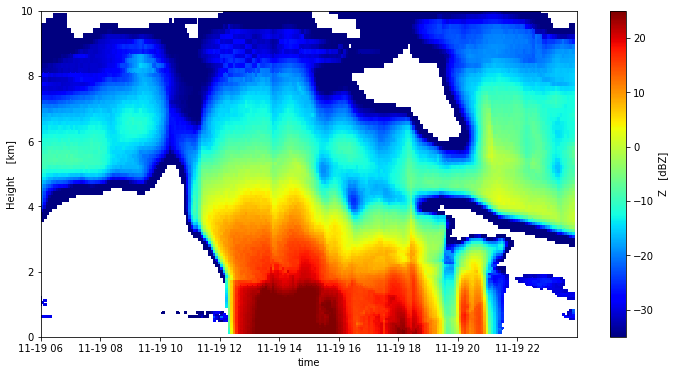

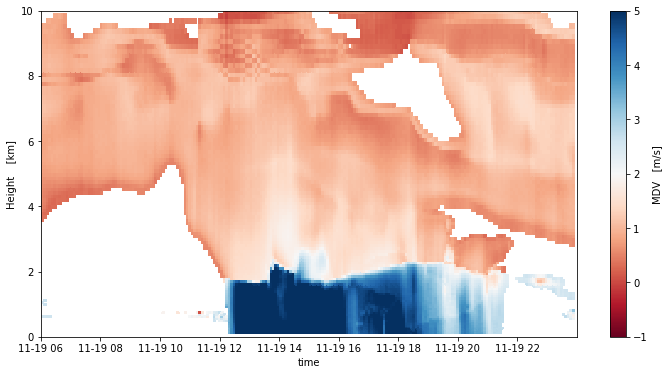

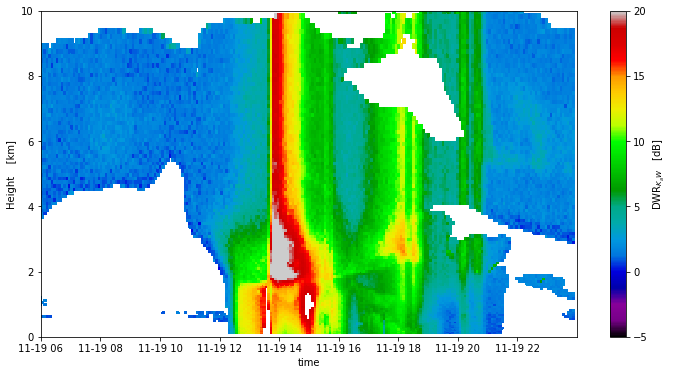

In [10]:
# Plot reflectivity Ka-band
fig1 = plt.figure(figsize=(12,6)); ax1 = plt.gca()
mesh1 = ax1.pcolormesh(tta, Ha*0.001, Zea-Aa, cmap='jet', vmin=Zmin, vmax=Zmax)
ax1.set_ylim(hlim)
ax1.set_xlim(timelim)
ax1.set_ylabel('Height    [km]')
ax1.set_xlabel('time')
plt.colorbar(mesh1, ax=ax1, label='Z   [dBZ]')

# Plot Mead Doppler Velocity Ka-band
fig2 = plt.figure(figsize=(12,6)); ax2 = plt.gca()
mesh2 = ax2.pcolormesh(tta, Ha*0.001, -MDVa, cmap='RdBu', vmin=Vmin, vmax=Vmax)
ax2.set_xlim(timelim)
ax2.set_ylim(hlim)
ax2.set_ylabel('Height    [km]')
ax2.set_xlabel('time')
plt.colorbar(mesh2, ax=ax2, label='MDV   [m/s]')

# Plot Dual wavelength ratio Ka-W
fig3 = plt.figure(figsize=(12,6)); ax3 = plt.gca()
mesh3 = ax3.pcolormesh(tta, Ha*0.001, (Zea-Aa-Zew+Aw),
                       cmap='nipy_spectral', vmin=Dmin, vmax=Dmax)
ax3.set_xlim(timelim)
ax3.set_ylim(hlim)
ax3.set_ylabel('Height    [km]')
ax3.set_xlabel('time')
plt.colorbar(mesh3, ax=ax3, label='DWR$_{K_aW}$   [dB]')

Plot the passive part

Text(0,0.5,'T$_b$   [K]')

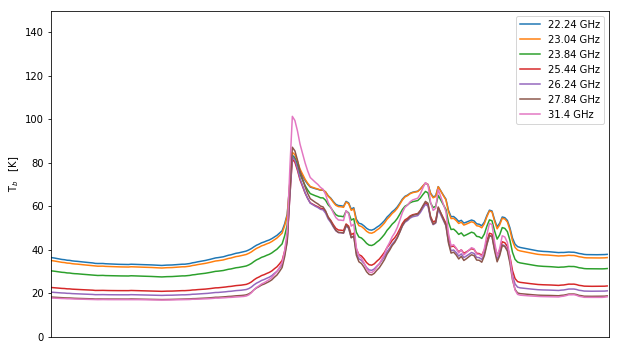

In [11]:
def getTime(ncdata, timevar):
  return nc.num2date(times=ncdata.variables[timevar][:],
                     units=ncdata.variables[timevar].units).squeeze()
def f2labels(frequencies):
  return [str(f)+' GHz' for f in frequencies]

fig4 = plt.figure(figsize=(10,6)); ax4 = plt.gca()
ax4.plot(getTime(pamP, 'datatime'), pamP.variables['tb'][:,0,1,31,:7,0]) # downwelling at 0 meters)
ax4.legend(f2labels(pamP.variables['frequency'][:7]))
ax4.set_xlim(timelim)
ax4.set_ylim(TlimK)
ax4.set_xlim(ax1.get_xlim())
ax4.get_xaxis().set_ticks([])
ax4.set_ylabel('T$_b$   [K]')
